# Spectrum simulation for CTA

A quick example how to simulate and fit a spectrum for the [Cherenkov Telescope Array (CTA)](https://www.cta-observatory.org)

We will use the following classes:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.scripts.CTAIrf](http://docs.gammapy.org/dev/api/gammapy.scripts.CTAIrf.html)

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw
from gammapy.irf import CTAIrf

## Simulation

In [3]:
# Define obs parameters
livetime = 10 * u.h
offset = 0.3 * u.deg
lo_threshold = 0.1 * u.TeV
hi_threshold = 60 * u.TeV

In [4]:
# Define spectral model
index = 2.3 * u.Unit('')
amplitude = 2.5 * 1e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV
model = PowerLaw(index=index, amplitude=amplitude, reference=reference)

In [5]:
# Load IRFs
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/South_5h/irf_file.fits.gz'
cta_irf = CTAIrf.read(filename)

NDDataArray summary info
energy         : size =   500, min =  0.005 TeV, max = 495.450 TeV
offset         : size =    45, min =  0.050 deg, max =  4.450 deg
Data           : size = 22500, min =  0.000 m2, max = 4033200.000 m2



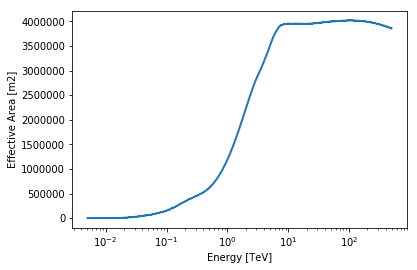

In [6]:
aeff = cta_irf.aeff.to_effective_area_table(offset=offset)
aeff.plot()
print(cta_irf.aeff.data)

NDDataArray summary info
e_true         : size =   500, min =  0.005 TeV, max = 495.450 TeV
e_reco         : size =   500, min =  0.005 TeV, max = 495.450 TeV
Data           : size = 250000, min =  0.000, max =  0.165



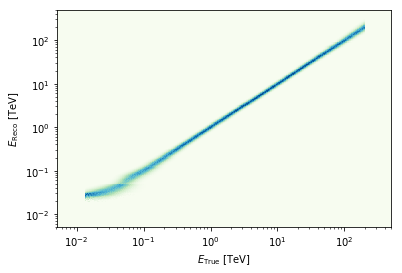

In [7]:
edisp = cta_irf.edisp.to_energy_dispersion(offset=offset)
edisp.plot_matrix()
print(edisp.data)

In [8]:
# Simulate data
aeff.lo_threshold = lo_threshold
aeff.hi_threshold = hi_threshold
sim = SpectrumSimulation(aeff=aeff, edisp=edisp, source_model=model, livetime=livetime)
sim.simulate_obs(seed=42, obs_id=0)

*** Observation summary report ***
Observation Id: 0
Livetime: 10.000 h
On events: 9975
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 9975.00
Excess / Background: inf
Gamma rate: 997.50 1 / h
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 0.01 TeV - 501.19 TeV


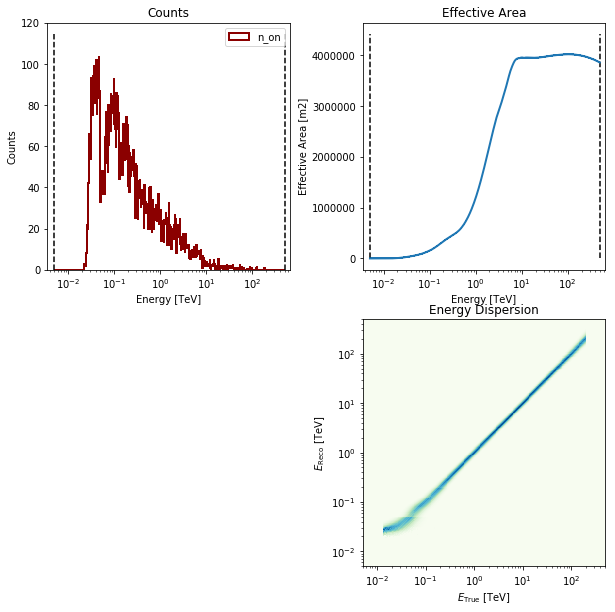

In [9]:
sim.obs.peek()
print(sim.obs)

## Spectral analysis

Now that we have some simulated CTA counts spectrum, let's analyse it.

In [10]:
# Fit data
fit = SpectrumFit(obs_list=sim.obs, model=model, stat='cash')
fit.run()
result = fit.result[0]

FCN = -56144.06653657953 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 8.642718267438146e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.30475,0.00658453,0,0,,,
2,par_001_amplitude,0.247143,0.00372272,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


In [11]:
print(result)


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.305e+00 6.585e-03                       nan nan
	amplitude 2.471e-12 3.723e-14 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name            index                 amplitude        reference
	--------- ----------------------- ----------------------- ---------
	    index  4.3356058336945256e-05 -1.8313152191134134e-16       0.0
	amplitude -1.8313152191134134e-16  1.3858672238130857e-27       0.0
	reference                     0.0                     0.0       0.0 

Statistic: -56144.067 (cash)
Fit Range: [5.01187239e-03 5.01187225e+02] TeV



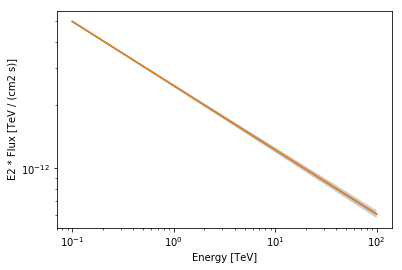

In [12]:
energy_range = [0.1, 100] * u.TeV
model.plot(energy_range=energy_range, energy_power=2)
result.model.plot(energy_range=energy_range, energy_power=2)
result.model.plot_error(energy_range=energy_range, energy_power=2)

## Exercises

* Change the observation time to something longer or shorter. Does the observation and spectrum results change as you expected?
* Change the spectral model, e.g. add a cutoff at 5 TeV, or put a steep-spectrum source with spectral index of 4.0

In [13]:
# Start the exercises here!

## What next?

In this tutorial we simulated and analysed the spectrum of source using CTA prod 2 IRFs.

If you'd like to go further, please see the other tutorial notebooks.